# Setting Up Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path_dataset_drive = '/content/drive/MyDrive/Python Data/SER/archive.zip'

In [ ]:
!mkdir dataset

In [ ]:
!cd dataset
!unzip '/content/drive/MyDrive/Python Data/SER/archive.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Python Data/SER/archive.zip
  inflating: /content/dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content/dataset/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: /c

In [ ]:
path_dataset = '/content/dataset'

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
path_list, label_list = [], []
for folder in sorted(os.listdir(path_dataset)):
  for f in sorted(os.listdir(os.path.join(path_dataset,folder))):
    temp_path= os.path.join(path_dataset,folder)
    temp_path = os.path.join(temp_path, str(f))
    if temp_path[-4:] == '.wav':
      path_list += temp_path,
      f = int(f[6:8])
      label_list += f,

In [ ]:
path_list[-1] # sample path for cross checking

'/content/dataset/Actor_24/03-01-08-02-02-02-24.wav'

In [ ]:
path_list[-1][-24:]

'03-01-08-02-02-02-24.wav'

In [ ]:
label_list[-1] # Checking to see if we got correct emotion

8

# Audio Feture Extraction

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['neutral', 'sad', 'angry', 'calm',
                   'happy', 'fearful', 'disgust', 'surprised']

In [ ]:
!pip install pydub --quiet

In [ ]:
from pydub import AudioSegment

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [ ]:
def load_data(path_list, emotions, observed_emotions, test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/content/dataset/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        sound = AudioSegment.from_wav(file)
        sound = sound.set_channels(1)
        sound.export(file, format="wav")
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train,x_test,y_train,y_test=load_data(path_list, emotions, observed_emotions, test_size=0.20)

# Model

In [ ]:
# x_train,x_test,y_train,y_test

In [ ]:
output_dict = {
  'neutral':0,
  'calm':1,
  'happy':2,
  'sad':3,
  'angry':4,
  'fearful':5,
  'disgust':6,
  'surprised':7
}

In [ ]:
def convert_y(y, output_dict):
  for idx,i in enumerate(y):
    y[idx] = output_dict[y[idx]]
  return np.array(y)

In [ ]:
y_train_c = convert_y(y_train, output_dict)
y_test_c = convert_y(y_test, output_dict)

In [ ]:
def convert_x(x):
  for idx,i in enumerate(x):
    x[idx] = np.array(i)
  return x

In [ ]:
x_train = convert_x(x_train)
x_test = convert_x(x_test)

In [ ]:
import tensorflow as tf

In [ ]:
input_shape = x_train.shape[1]

In [ ]:
def build_model(input_shape):
    input_shape = (input_shape,) #Input Size if equal to no. of columns

    ser_model = tf.keras.models.Sequential()

    ser_model.add(tf.keras.layers.Dense(units = 2048, activation='relu',
                                        input_shape=input_shape))
    ser_model.add(tf.keras.layers.Dropout(0.1)),
    ser_model.add(tf.keras.layers.Dense(units=2048, activation='relu')),
    ser_model.add(tf.keras.layers.Dropout(0.3)),
    ser_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))

    opt = tf.keras.optimizers.Adam()
    #Compiling the model with optimizer, loss and metric to br tracked
    ser_model.compile(optimizer=opt,
                loss='SparseCategoricalCrossentropy',
                metrics=['accuracy'])

    return ser_model

In [ ]:
ser_model = build_model(input_shape)

In [ ]:
ser_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              370688    
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 4,583,432
Trainable params: 4,583,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=40)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        'ser_model.hdf5',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')

In [ ]:
history = ser_model.fit(x=x_train,y= np.array(y_train_c),
              validation_data=(x_test, np.array(y_test_c)),
              epochs=1000,
              callbacks=[stop_early, checkpoint])

Epoch 1/1000
31/36 [========================>.....] - ETA: 0s - loss: 64.7140 - accuracy: 0.1381
Epoch 1: val_loss improved from inf to 7.03800, saving model to ser_model.hdf5
36/36 [==============================] - 5s 31ms/step - loss: 57.1438 - accuracy: 0.1458 - val_loss: 7.0380 - val_accuracy: 0.1597
Epoch 2/1000
27/36 [=====================>........] - ETA: 0s - loss: 4.7927 - accuracy: 0.1852
Epoch 2: val_loss improved from 7.03800 to 1.85290, saving model to ser_model.hdf5
36/36 [==============================] - 0s 14ms/step - loss: 4.2093 - accuracy: 0.1892 - val_loss: 1.8529 - val_accuracy: 0.3090
Epoch 3/1000
34/36 [===========================>..] - ETA: 0s - loss: 1.9579 - accuracy: 0.2463
Epoch 3: val_loss improved from 1.85290 to 1.84331, saving model to ser_model.hdf5
36/36 [==============================] - 1s 16ms/step - loss: 1.9548 - accuracy: 0.2474 - val_loss: 1.8433 - val_accuracy: 0.2812
Epoch 4/1000
30/36 [========================>.....] - ETA: 0s - loss: 1.923

In [ ]:
# 128x2, 64x3, 32x0 - 59.72%
# 256x1 - 52.43%
# 512x1 - 56.60%
# 2048x1 - 69.44%
# 4096x1 - 69.10%
# 2048x1, 64x1 - 67.71%
# 2048x1, 128x1 - 65.28%
# 2048x1, 256x1 - 69.10%
# 2048x1, 512x1 - 69.79%
# 2048x1, 2048x1, dropout(0.2) - 69.44% - Training - 90%
# 2048x1, 2048x1, dropout(0.4) - 68.40% - Training - 80%
# 1024x1, 2048x1, dropout(0.5) - 69.79% - Training - 92%

In [ ]:
import matplotlib.pyplot as plt

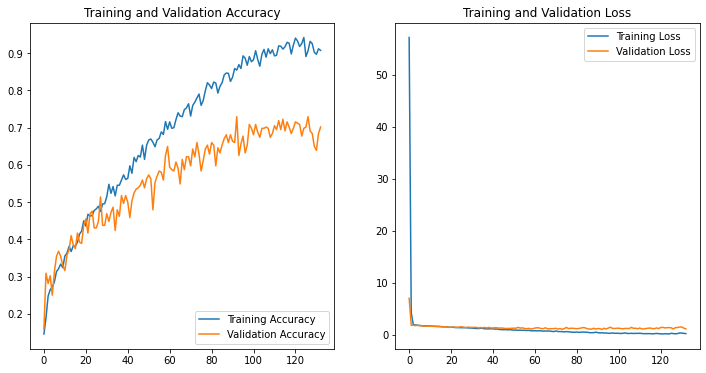

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(f'the Accuracy of the model is {max(val_acc)}')

the Accuracy of the model is 0.7291666865348816
